<a href="https://colab.research.google.com/github/plusbpm/colab-notebooks/blob/main/%D0%94%D0%97%E2%84%9617_%D0%93%D0%B5%D0%BD%D0%B5%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D1%8B%D0%B5_%D1%81%D0%BE%D1%81%D1%82%D1%8F%D0%B7%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D1%81%D0%B5%D1%82%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Подготовка

In [1]:
!pip install --upgrade --no-cache-dir gdown
import tensorflow as tf
from tensorflow.keras import layers, optimizers, utils, models, callbacks, preprocessing, datasets, backend as K, losses, metrics, activations
from sklearn import preprocessing as skpreprocessing, model_selection
import pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns
import os, re, random, time, sys
import IPython.display as ipd
from PIL import Image, ImageDraw, ImageOps

sns.set_style('darkgrid')
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# https://drive.google.com/file/d/1zw2VL1lrbzfQbARHTEjUfxeBamfny_qN/view?usp=sharing
# !gdown --help
# !gdown --id 1zw2VL1lrbzfQbARHTEjUfxeBamfny_qN
!gdown 1zw2VL1lrbzfQbARHTEjUfxeBamfny_qN

# https://drive.google.com/file/d/1pPni0kS1A6DfndmO_mYc7dZfWLNSlMRQ/view?usp=sharing
# https://drive.google.com/file/d/1pPni0kS1A6DfndmO_mYc7dZfWLNSlMRQ/view?usp=sharing
!gdown 1pPni0kS1A6DfndmO_mYc7dZfWLNSlMRQ


Downloading...
From: https://drive.google.com/uc?id=1zw2VL1lrbzfQbARHTEjUfxeBamfny_qN
To: /content/Airplanes.zip
100% 106M/106M [00:01<00:00, 97.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pPni0kS1A6DfndmO_mYc7dZfWLNSlMRQ
To: /content/AirplanesSegment.zip
100% 43.2M/43.2M [00:01<00:00, 33.5MB/s]


In [3]:
!rm -rf /content/data

!unzip -q /content/Airplanes.zip -d data && rm -f /content/Airplanes.zip
!unzip -q /content/AirplanesSegment.zip -d data && rm -f /content/AirplanesSegment.zip

In [4]:
base_dir = '/content/data'
# оригинал 1920x1080x3
target_sizes = (192, 108)
# target_sizes = (96, 54)

for typedir in os.listdir(base_dir):
  full_typedir = os.path.join(base_dir, typedir)
  for filename in os.listdir(full_typedir):
    filePath = os.path.join(full_typedir, filename)
    try:
      img = Image.open(filePath)
      img = img.resize(target_sizes)
      img.save(filePath)
    except Exception:
      print(filePath, '=>', sys.exc_info()[0])
      os.remove(filePath)

In [5]:
x_train = []
masks_full = []

for typedir in os.listdir(base_dir):
  destination_is_masks = typedir == 'Segment'
  destination = masks_full if destination_is_masks else x_train
  full_typedir = os.path.join(base_dir, typedir)
  for filename in os.listdir(full_typedir):
    filePath = os.path.join(full_typedir, filename)
    img = Image.open(filePath)
    img = ImageOps.grayscale(img) if destination_is_masks else img
    img_arr = np.array(img)
    img_arr = np.expand_dims(img_arr, axis=2) if destination_is_masks else img_arr
    destination.append(img_arr)

x_train = np.array(x_train) / 255
masks = np.array(masks_full) / 255
# masks = (masks_full[:,:,:, [0]] > 127).astype('uint')

# Обучение

In [11]:
# noise_dim = 108
noise_dim = 1000
img_shape = x_train[0].shape
img_vol = np.prod(img_shape)
mask_shape = masks[0].shape
batch_size=20
print('img_shape', img_shape, '\nmask_shape', mask_shape)

img_shape (108, 192, 3) 
mask_shape (108, 192, 1)


In [12]:
def craft_generator():
  mask_input = layers.Input(shape=mask_shape)
  mask = layers.Conv2D(128, 2, 2, padding="same", activation="relu")(mask_input)
  mask = layers.Conv2D(128, 3, 2, padding="same", activation="relu")(mask)
  mask = layers.Conv2D(128, 3, 3, padding="same", activation="relu")(mask)
  noise_input = layers.Input(shape=(noise_dim,))

  gen = layers.Dense(432, activation="relu")(noise_input)
  gen = layers.Reshape((9, 16, 3))(gen)
  # gen = layers.concatenate([gen, mask])


  gen = layers.BatchNormalization()(gen)
  gen1_1 = layers.Conv2DTranspose(32, 2, 2, padding="same", activation="sigmoid")(gen)
  gen1_2 = layers.Conv2DTranspose(32, 3, 2, padding="same", activation="sigmoid")(gen)
  gen = layers.concatenate([gen1_1, gen1_2])

  gen2_2 = layers.Conv2DTranspose(64, 3, 2, padding="same", activation="sigmoid")(gen)
  gen2_3 = layers.Conv2DTranspose(64, 4, 2, padding="same", activation="sigmoid")(gen)
  gen2_4 = layers.Conv2DTranspose(64, 5, 2, padding="same", activation="sigmoid")(gen)
  gen = layers.concatenate([gen2_2, gen2_3, gen2_4])

  gen3_3 = layers.Conv2DTranspose(128, 5, 3, padding="same", activation="sigmoid")(gen)
  gen3_5 = layers.Conv2DTranspose(128, 7, 3, padding="same", activation="sigmoid")(gen)
  gen = layers.concatenate([gen3_3, gen3_5, mask_input])

  gen8 = layers.Conv2D(64, 5, padding="same", activation="relu")(gen)
  gen9 = layers.Conv2D(64, 3, padding="same", activation="relu")(gen)
  gen10 = layers.Conv2D(64, 2, padding="same", activation="relu")(gen)
  gen = layers.concatenate([gen8, gen9, gen10])

  # gen = layers.Conv2D(16, 3, padding="same", activation="relu")(gen)
  # gen = layers.Conv2D(16, 2, padding="same", activation="relu")(gen)
  gen = layers.Conv2D(16, 3, padding="same", activation="relu")(gen)
  gen = layers.Conv2D(img_shape[2], 2, padding="same", activation="sigmoid")(gen)

  return models.Model([noise_input, mask_input], gen, name="generator")

def craft_discriminator():
  img_input = layers.Input(shape=img_shape)
  
  mask_input = layers.Input(shape=mask_shape)
  dscr = layers.concatenate([img_input, mask_input])

  dscr1 = layers.Conv2D(64, 2, 2, padding="same", activation="relu")(dscr)
  dscr2 = layers.Conv2D(64, 3, 2, padding="same", activation="relu")(dscr)
  dscr3 = layers.Conv2D(64, 4, 2, padding="same", activation="relu")(dscr)
  dscr4 = layers.Conv2D(64, 5, 2, padding="same", activation="relu")(dscr)
  dscr5 = layers.Conv2D(64, 6, 2, padding="same", activation="relu")(dscr)
  dscr6 = layers.Conv2D(64, 7, 2, padding="same", activation="relu")(dscr)
  dscr = layers.concatenate([dscr1, dscr2, dscr3, dscr4, dscr5, dscr6])
  dscr = layers.Dropout(0.5)(dscr)


  dscr1 = layers.Conv2D(32, 2, 2, padding="same", activation="relu")(dscr)
  dscr2 = layers.Conv2D(32, 3, 2, padding="same", activation="relu")(dscr)
  dscr3 = layers.Conv2D(32, 4, 2, padding="same", activation="relu")(dscr)
  dscr4 = layers.Conv2D(32, 5, 2, padding="same", activation="relu")(dscr)
  dscr = layers.concatenate([dscr1, dscr2, dscr3, dscr4])
  dscr = layers.Dropout(0.4)(dscr)

  dscr1 = layers.Conv2D(16, 3, 3, padding="same", activation="relu")(dscr)
  dscr2 = layers.Conv2D(16, 4, 3, padding="same", activation="relu")(dscr)
  dscr = layers.concatenate([dscr1, dscr2])
  dscr = layers.Dropout(0.4)(dscr)

  dscr = layers.Flatten()(dscr)
  dscr = layers.Dense(1, activation="sigmoid")(dscr)

  return models.Model([img_input, mask_input], dscr, name="discriminator")

def craft_overall_model(gna, dsa):
  noise_input = layers.Input(shape=(noise_dim,))
  mask_input = layers.Input(shape=mask_shape)
  gen_out_tf = gna([noise_input, mask_input])
  dscr_out_tf = dsa([gen_out_tf, mask_input])
  return models.Model([noise_input, mask_input], dscr_out_tf, name="overall_model")

def training_process(gna, dsa, ovl, epochs=50, preview_period=50, with_log=True):
  y_true = np.ones((batch_size, 1))
  y_false = np.zeros((batch_size, 1))

  hist = {
      "Dloss": [],
      "Dacc": [],
      "Gloss": [],
      "Gacc": [],
  }

  for epoch in range(epochs):
    begin = time.time()

    inxs = np.random.randint(0, x_train.shape[0], batch_size)
    # inxs1 = np.random.randint(0, x_train.shape[0], batch_size)
    real_imgs = x_train[inxs]
    real_masks = masks[inxs]
    # real_masks1 = masks[inxs1]

    noise = np.random.normal(0, 1, (batch_size, noise_dim))
    generated_imgs = gna.predict([noise, real_masks])

    realLoss, realAcc = dsa.train_on_batch([real_imgs, real_masks], y_true)
    genLoss, genAcc = dsa.train_on_batch([generated_imgs, real_masks], y_false)
    ovlLoss, ovlAcc = ovl.train_on_batch([noise, real_masks], y_true)

    hist["Dloss"].append(np.mean([realLoss, genLoss]))
    hist["Dacc"].append(np.mean([realAcc, genAcc]) * 100)
    hist["Gloss"].append(ovlLoss)
    hist["Gacc"].append(ovlAcc * 100)

    end = time.time()
    def print_log():
      print(f"{epoch}: ({end - begin:.3f}s) D -> [loss: {hist['Dloss'][-1]}({realLoss:.4f}|{genLoss:.4f}), acc: {hist['Dacc'][-1]:.2f} (r:{realAcc*100:.2f}|g:{genAcc*100:.2f})] G -> [{hist['Gloss'][-1]}, acc: {hist['Gacc'][-1]:.2f}]")

    if with_log:
      print_log()

    if epoch > 1 and epoch % preview_period is 0:
      print_log()
      preview_predict(gna, test_samples_count=1)

  return hist
  
def draw_history(h):
  f, axs = plt.subplots(1, 2, figsize=(15, 5))
  axs[0].plot(h["Dloss"], label="Ошибка дискриминатора")
  axs[0].plot(h["Gloss"], label="Ошибка генератора")
  axs[0].legend()
  axs[1].plot(h["Dacc"], label="Точность дискриминатора")
  axs[1].legend()
  plt.show()

def preview_predict(generator, test_samples_count=3):
  single_image = test_samples_count is 1
  noise = np.random.normal(0, 1, (test_samples_count, noise_dim))
  random_inxs = np.random.randint(0, masks.shape[0], size=test_samples_count)
  # random_inxs = np.array([0, 0, 0])
  random_imgs = x_train[random_inxs]
  random_masks = masks[random_inxs]
  generated_images = (generator.predict([noise, random_masks]) * 255).astype('uint8')

  columns = 3 if single_image else test_samples_count

  def plot_images(imgs):
    f, axis = plt.subplots(1, columns, figsize=(20,8))
    for ax, img in zip(axis, imgs):
      ax.imshow(img)
    plt.show()

  if single_image:
    plot_images([random_imgs[0], np.dstack((random_masks[0],random_masks[0],random_masks[0])) , generated_images[0]])
  else:
    plot_images(random_imgs)
    plot_images(random_masks)
    plot_images(generated_images)


In [13]:
K.clear_session()
gener = craft_generator()

discrer = craft_discriminator()
discrer.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])
discrer.trainable = False

overall = craft_overall_model(gener, discrer)
overall.compile(loss="binary_crossentropy", optimizer=optimizers.Adam(learning_rate=0.001), metrics=['accuracy'])

In [14]:
# discrer.summary()

20: (1.158s) D -> [loss: 0.2337176278233528(0.2302|0.2372), acc: 95.00 (r:90.00|g:100.00)] G -> [2.8753247261047363, acc: 0.00]


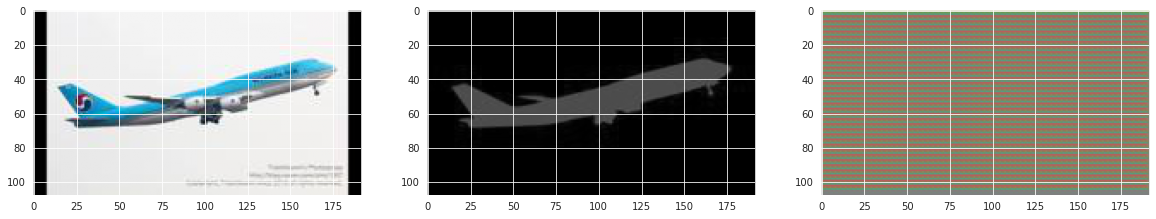

40: (1.141s) D -> [loss: 0.02210143953561783(0.0312|0.0130), acc: 100.00 (r:100.00|g:100.00)] G -> [6.868585109710693, acc: 0.00]


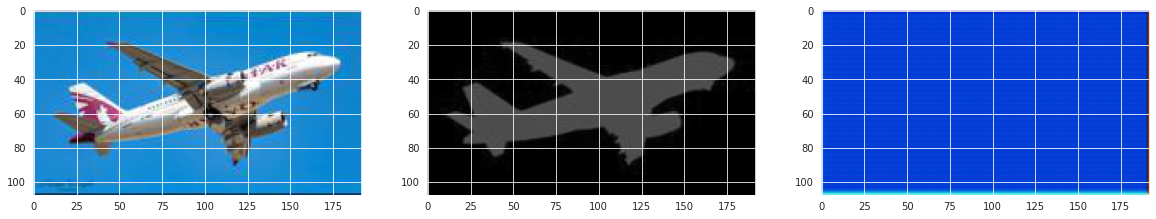

60: (1.131s) D -> [loss: 0.1705534220673144(0.3286|0.0125), acc: 97.50 (r:95.00|g:100.00)] G -> [4.770226955413818, acc: 0.00]


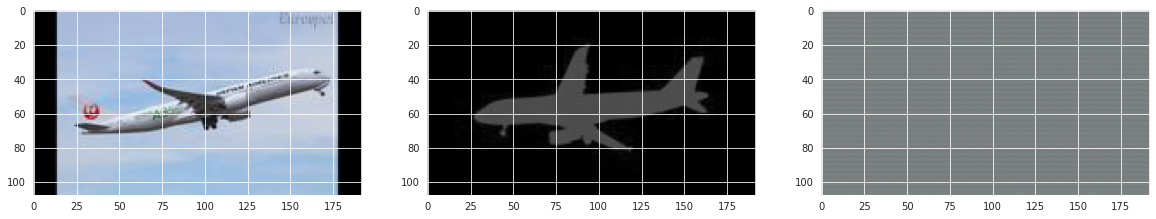

80: (1.123s) D -> [loss: 0.1522984839975834(0.0924|0.2122), acc: 97.50 (r:95.00|g:100.00)] G -> [1.7509801387786865, acc: 0.00]


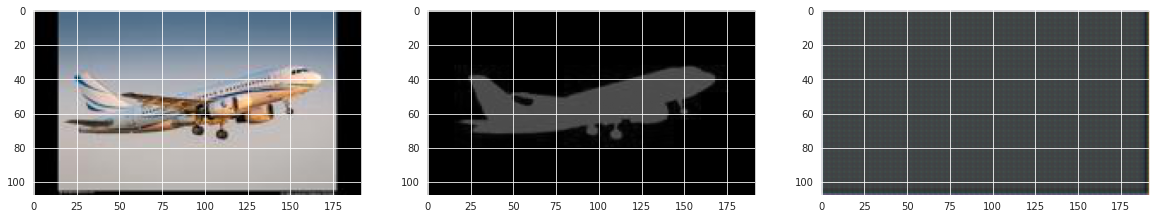

100: (1.123s) D -> [loss: 0.10703138262033463(0.1386|0.0754), acc: 97.50 (r:95.00|g:100.00)] G -> [3.264263153076172, acc: 0.00]


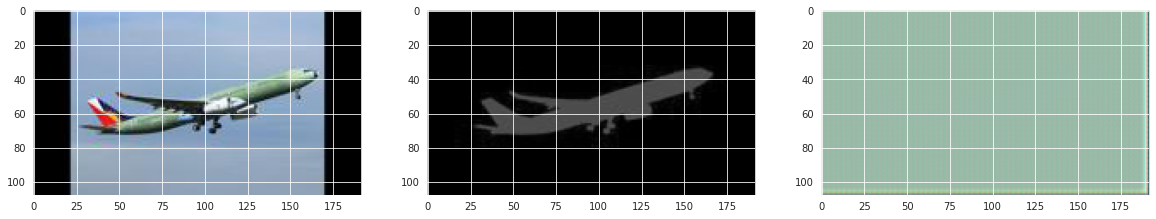

120: (1.121s) D -> [loss: 0.36962249130010605(0.5963|0.1430), acc: 92.50 (r:85.00|g:100.00)] G -> [2.572141170501709, acc: 0.00]


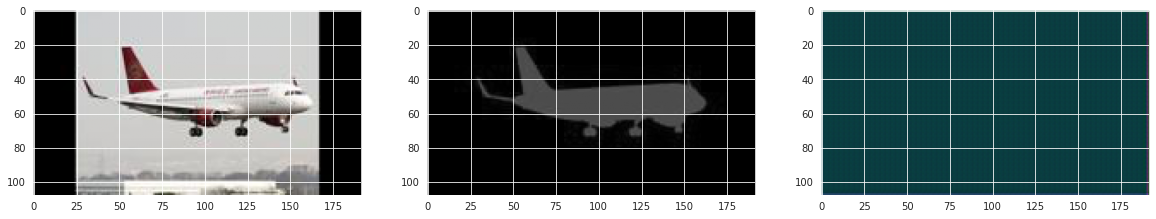

140: (1.257s) D -> [loss: 0.16578441858291626(0.1674|0.1641), acc: 97.50 (r:95.00|g:100.00)] G -> [3.319908618927002, acc: 0.00]


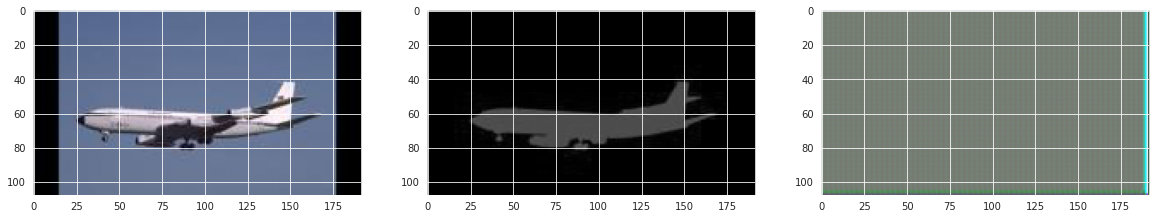

160: (1.119s) D -> [loss: 0.013813744299846165(0.0000|0.0276), acc: 100.00 (r:100.00|g:100.00)] G -> [4.006836414337158, acc: 0.00]


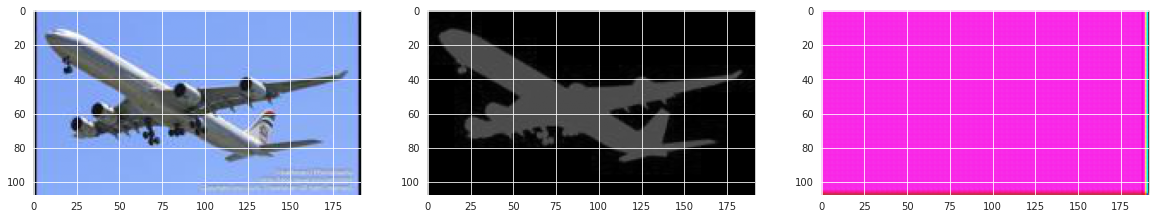

180: (1.122s) D -> [loss: 0.00020044983597244936(0.0000|0.0004), acc: 100.00 (r:100.00|g:100.00)] G -> [8.178357124328613, acc: 0.00]


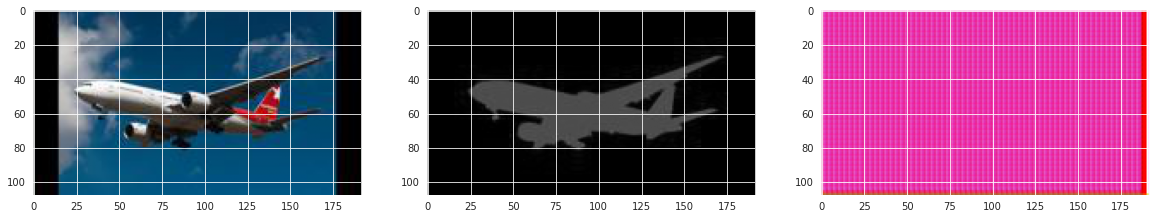

200: (1.127s) D -> [loss: 0.046269784681499004(0.0834|0.0091), acc: 97.50 (r:95.00|g:100.00)] G -> [5.535937786102295, acc: 0.00]


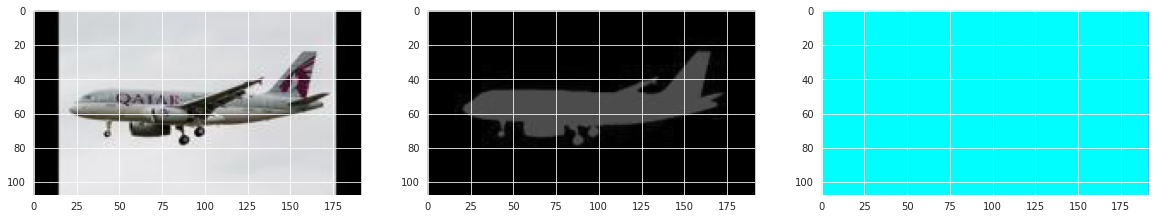

220: (1.127s) D -> [loss: 0.0011930433897617831(0.0024|0.0000), acc: 100.00 (r:100.00|g:100.00)] G -> [20.467111587524414, acc: 0.00]


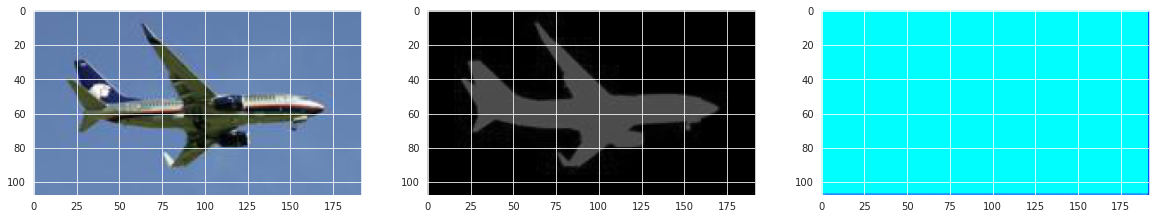

240: (1.122s) D -> [loss: 0.06656499124983384(0.1331|0.0000), acc: 97.50 (r:95.00|g:100.00)] G -> [9.395889282226562, acc: 0.00]


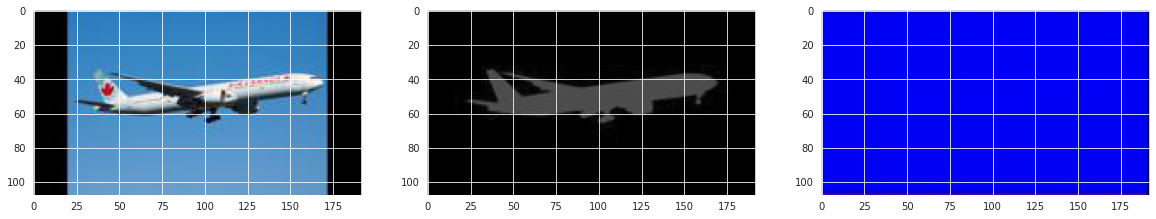

260: (1.116s) D -> [loss: 0.03541965480417275(0.0000|0.0708), acc: 100.00 (r:100.00|g:100.00)] G -> [3.0142388343811035, acc: 0.00]


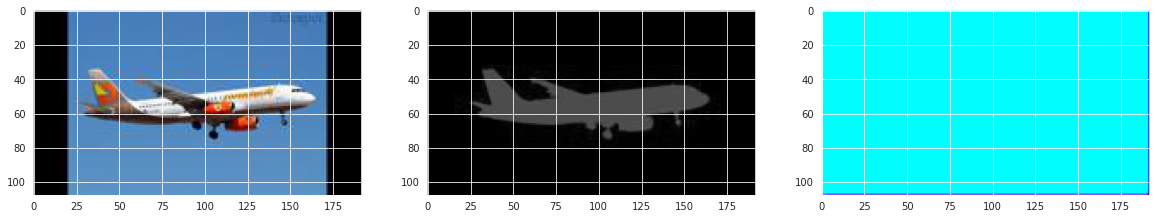

280: (1.120s) D -> [loss: 1.4995382092497742(2.9991|0.0000), acc: 90.00 (r:80.00|g:100.00)] G -> [12.193227767944336, acc: 0.00]


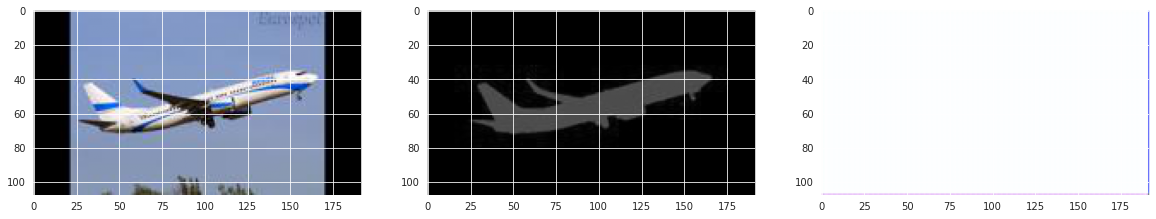

300: (1.258s) D -> [loss: 0.13033805415034294(0.2227|0.0380), acc: 95.00 (r:90.00|g:100.00)] G -> [4.536983966827393, acc: 0.00]


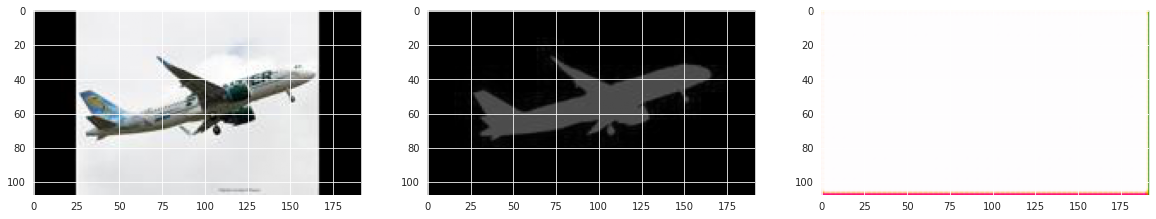

320: (1.124s) D -> [loss: 0.008533328538760543(0.0150|0.0020), acc: 100.00 (r:100.00|g:100.00)] G -> [11.17439079284668, acc: 0.00]


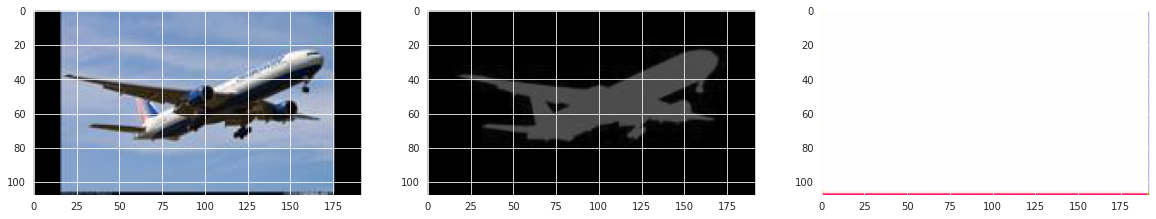

340: (1.124s) D -> [loss: 0.13667917251586914(0.1811|0.0922), acc: 95.00 (r:90.00|g:100.00)] G -> [2.873652219772339, acc: 0.00]


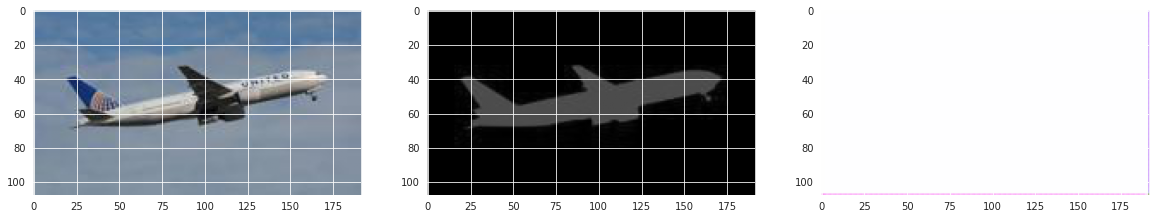

360: (1.123s) D -> [loss: 0.05957011133432388(0.0413|0.0778), acc: 100.00 (r:100.00|g:100.00)] G -> [5.347330570220947, acc: 0.00]


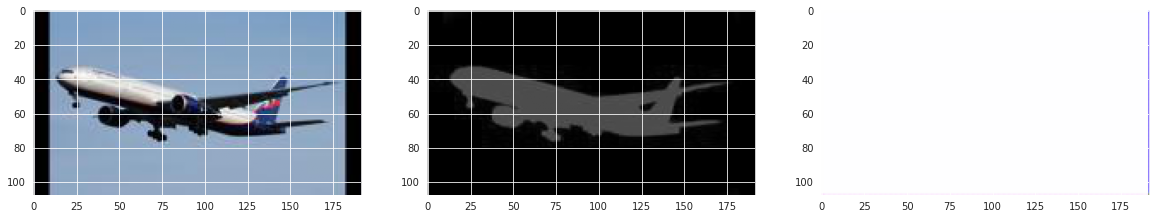

380: (1.134s) D -> [loss: 0.002705230377614498(0.0000|0.0054), acc: 100.00 (r:100.00|g:100.00)] G -> [6.754206657409668, acc: 0.00]


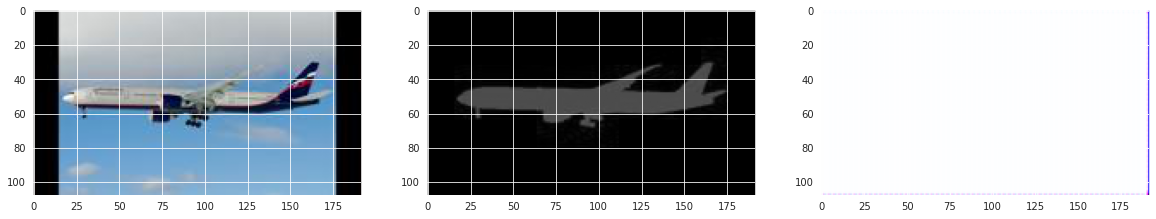

400: (1.136s) D -> [loss: 0.02467697072734154(0.0000|0.0493), acc: 100.00 (r:100.00|g:100.00)] G -> [5.377832889556885, acc: 0.00]


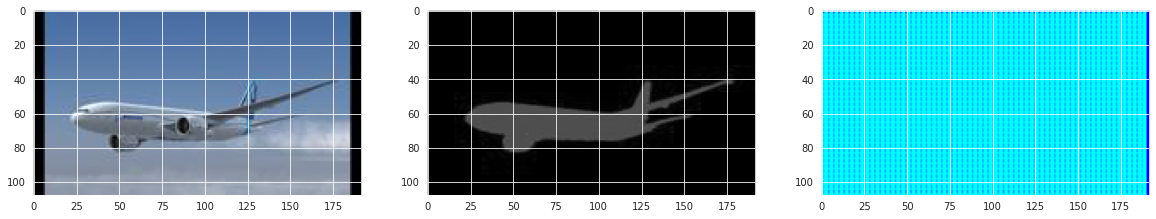

420: (1.127s) D -> [loss: 2.2499205648912692(4.4998|0.0000), acc: 90.00 (r:80.00|g:100.00)] G -> [15.541082382202148, acc: 0.00]


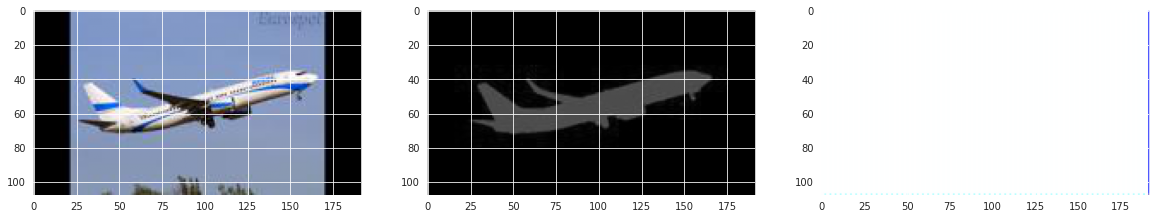

In [ ]:
hh = training_process(gener, discrer, overall, epochs=5000, preview_period=20, with_log=False)

In [ ]:
draw_history(hh)

In [ ]:
preview_predict(gener)
